In [ ]:
pip install pandas_market_calendars

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
# Load data
data = pd.read_csv('MSFT_2006-01-01_to_2018-01-01.csv')

# Data summary and visualization
print("Dataset Head:\n", data.head())
print("Dataset Shape:\n",data.shape)

Dataset Head:
          Date   Open   High    Low  Close     Volume  Name
0  03/01/2006  26.25  27.00  26.10  26.84   79974418  MSFT
1  04/01/2006  26.77  27.08  26.77  26.97   57975661  MSFT
2  05/01/2006  26.96  27.13  26.91  26.99   48247610  MSFT
3  06/01/2006  26.89  27.00  26.49  26.91  100969092  MSFT
4  09/01/2006  26.93  27.07  26.76  26.86   55627836  MSFT
Dataset Shape:
 (3019, 7)


In [ ]:
# Remove last column (constant value)
data = data.iloc[:, :-1]

# Check for missing values
missing = data.isnull().any(axis=1)
print("Rows with missing values:\n", data[missing])


Rows with missing values:
 Empty DataFrame
Columns: [Date, Open, High, Low, Close, Volume]
Index: []


In [ ]:
# Date processing for trading days per year
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
years = data['Date'].dt.year
unique_years = years.unique()
date_counts = [sum(years == year) for year in unique_years]

In [ ]:
#data.set_index('Date', inplace=True)

# Check the distribution of time intervals between observations
interval_distribution = data.index.to_series().diff().value_counts()
print("Distribution of Time Intervals Between Observations:")
print(interval_distribution)

Distribution of Time Intervals Between Observations:
1.0    3018
Name: count, dtype: int64


In [ ]:
# Display yearly count table
yearly_counts = pd.DataFrame({'Year': unique_years, 'Count': date_counts})
print(yearly_counts)

    Year  Count
0   2006    251
1   2007    251
2   2008    253
3   2009    252
4   2010    251
5   2011    252
6   2012    250
7   2013    252
8   2014    252
9   2015    252
10  2016    252
11  2017    251


In [ ]:
# Display date range
print("Date Range:", data['Date'].min(), "to", data['Date'].max())

Date Range: 2006-01-03 00:00:00 to 2017-12-29 00:00:00


In [ ]:
# Summary statistics
print(data.describe())

                                Date         Open         High          Low  \
count                           3019  3019.000000  3019.000000  3019.000000   
mean   2012-01-01 20:00:33.388539392    36.496817    36.827903    36.173190   
min              2006-01-03 00:00:00    15.200000    15.620000    14.870000   
25%              2009-01-01 00:00:00    26.785000    27.045000    26.535000   
50%              2011-12-30 00:00:00    29.990000    30.230000    29.780000   
75%              2015-01-01 00:00:00    44.545000    44.980000    44.090000   
max              2017-12-29 00:00:00    87.120000    87.500000    86.230000   
std                              NaN    14.683337    14.742483    14.620057   

             Close        Volume  
count  3019.000000  3.019000e+03  
mean     36.513412  5.161762e+07  
min      15.150000  7.425603e+06  
25%      26.835000  3.136557e+07  
50%      30.000000  4.617529e+07  
75%      44.400000  6.322291e+07  
max      86.850000  5.910786e+08  
std     

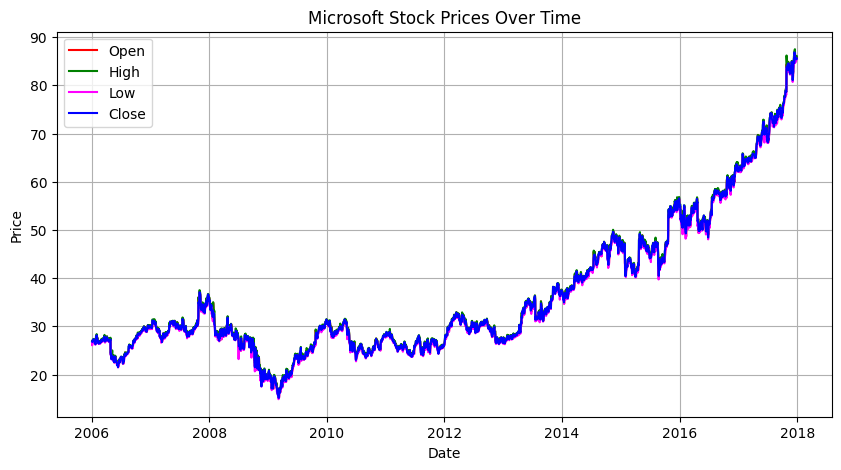

In [ ]:
# Data Visualization - Time Series Analysis
plt.figure(figsize=(10, 5))
plt.plot(data['Date'], data['Open'], label='Open', color='red')
plt.plot(data['Date'], data['High'], label='High', color='green')
plt.plot(data['Date'], data['Low'], label='Low', color='magenta')
plt.plot(data['Date'], data['Close'], label='Close', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Microsoft Stock Prices Over Time')
plt.legend()
plt.grid(True)
plt.show()

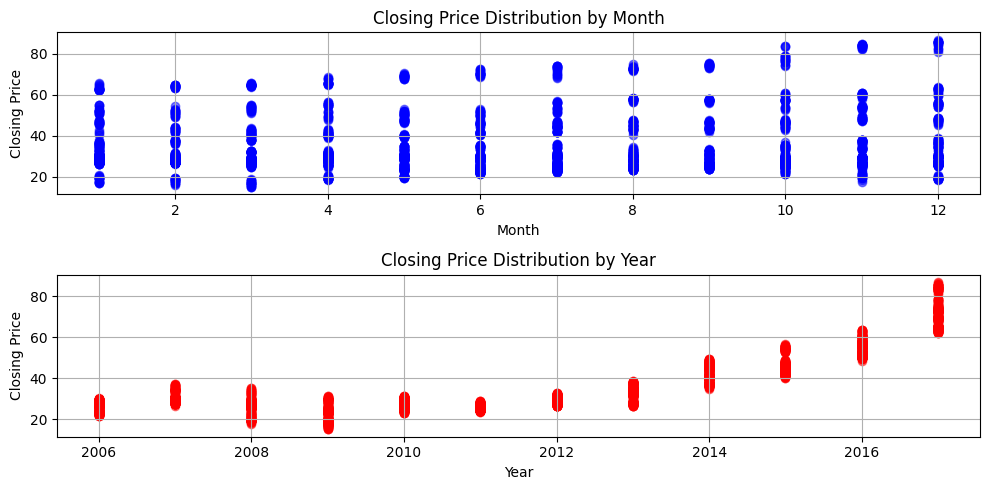

In [ ]:
# Closing Price Distribution over Months and Years
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.scatter(data['Date'].dt.month, data['Close'], color='b', alpha=0.5)
plt.title('Closing Price Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Closing Price')
plt.grid(True)


plt.subplot(2, 1, 2)
plt.scatter(data['Date'].dt.year, data['Close'], color='r', alpha=0.5)
plt.title('Closing Price Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Correlation between Volume and Close Price
correlation_coefficient = data['Close'].corr(data['Volume'])
print(f'The correlation between Volume and Close Price is: {correlation_coefficient:.4f}')


The correlation between Volume and Close Price is: -0.4853


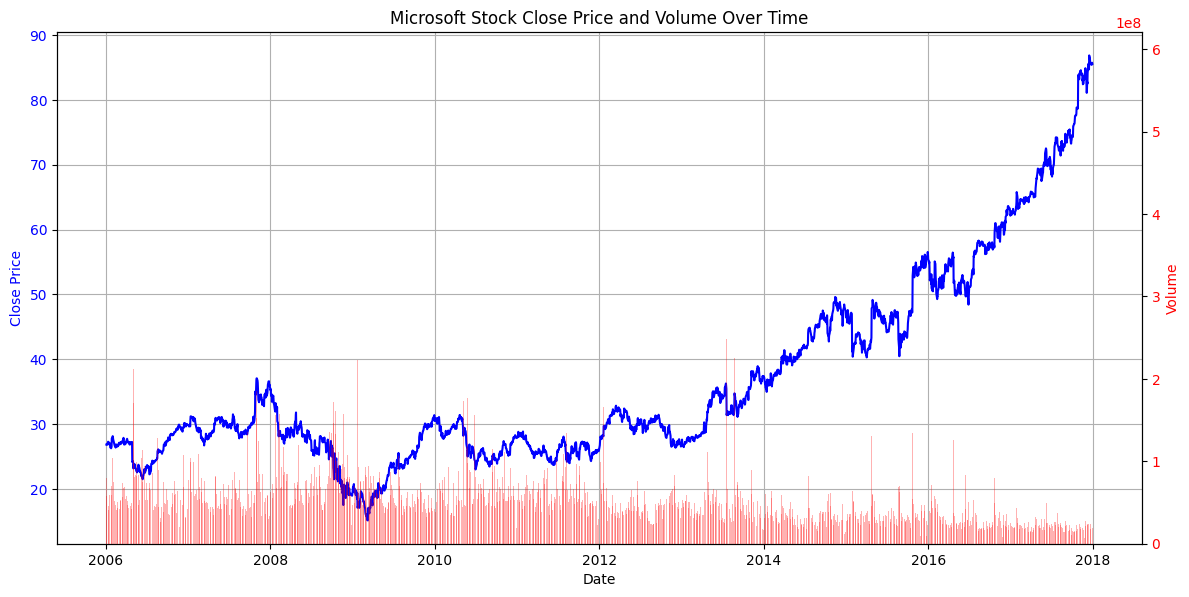

In [ ]:
# Dual-axis plot for Close Price vs. Volume
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(data['Date'], data['Close'], 'b-', linewidth=1.5, label='Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.bar(data['Date'], data['Volume'], alpha=0.3, color='r', width=1.5)
ax2.set_ylabel('Volume', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.tight_layout()
plt.title('Microsoft Stock Close Price and Volume Over Time')
plt.show()

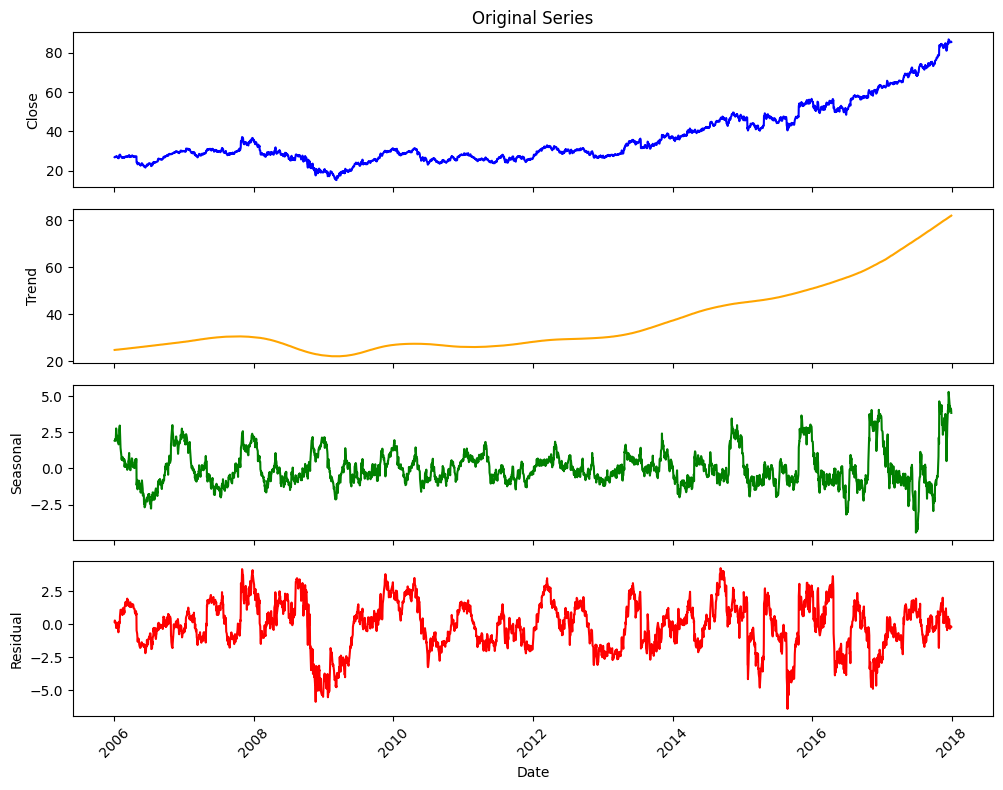

In [ ]:
from statsmodels.tsa.seasonal import STL

# Perform seasonal decomposition using STL (Seasonal-Trend decomposition using LOESS)
stl = STL(data['Close'], period=252)
result = stl.fit()
trend = result.trend
seasonal = result.seasonal
residual = result.resid

fig, ax = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

# Original series
ax[0].plot(data['Date'], data['Close'], color='blue')
ax[0].set_ylabel('Close')
ax[0].set_title('Original Series')

# Trend component
ax[1].plot(data['Date'], trend, color='orange')
ax[1].set_ylabel('Trend')

# Seasonal component
ax[2].plot(data['Date'], seasonal, color='green')
ax[2].set_ylabel('Seasonal')

# Residuals
ax[3].plot(data['Date'], residual, color='red')
ax[3].set_ylabel('Residual')

plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


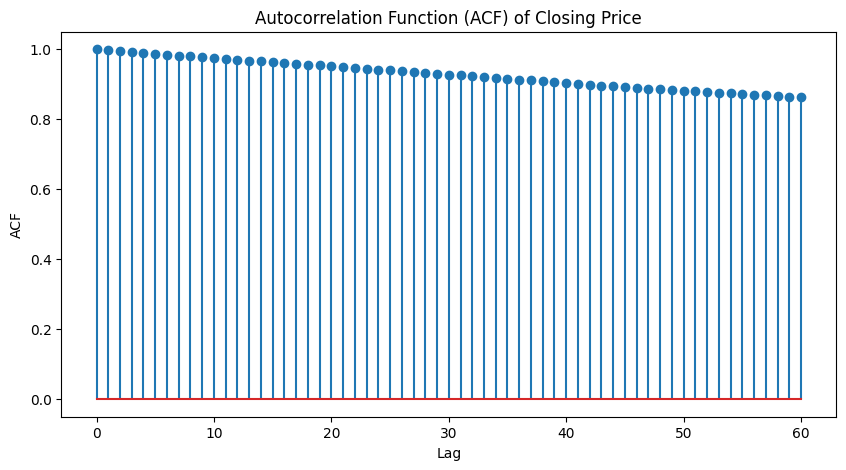

In [ ]:
# Autocorrelation Analysis
lags = 60
acf_values = acf(data['Close'], nlags=lags)
plt.figure(figsize=(10, 5))
plt.stem(range(lags + 1), acf_values)
plt.title('Autocorrelation Function (ACF) of Closing Price')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

<Figure size 1000x500 with 0 Axes>

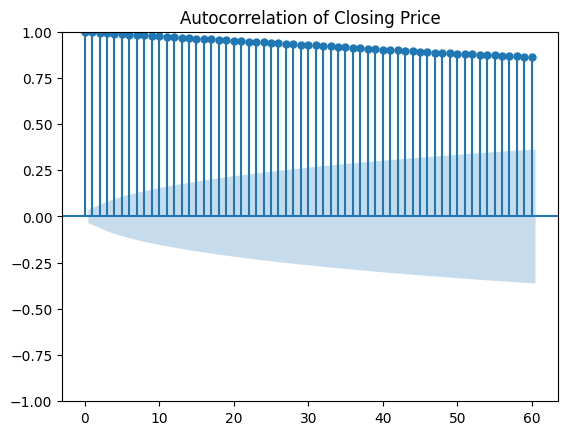

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# Autocorrelation of Close Price
plt.figure(figsize=(10, 5))
plot_acf(data['Close'], lags=60)
plt.title('Autocorrelation of Closing Price')
plt.show()

# Week 2

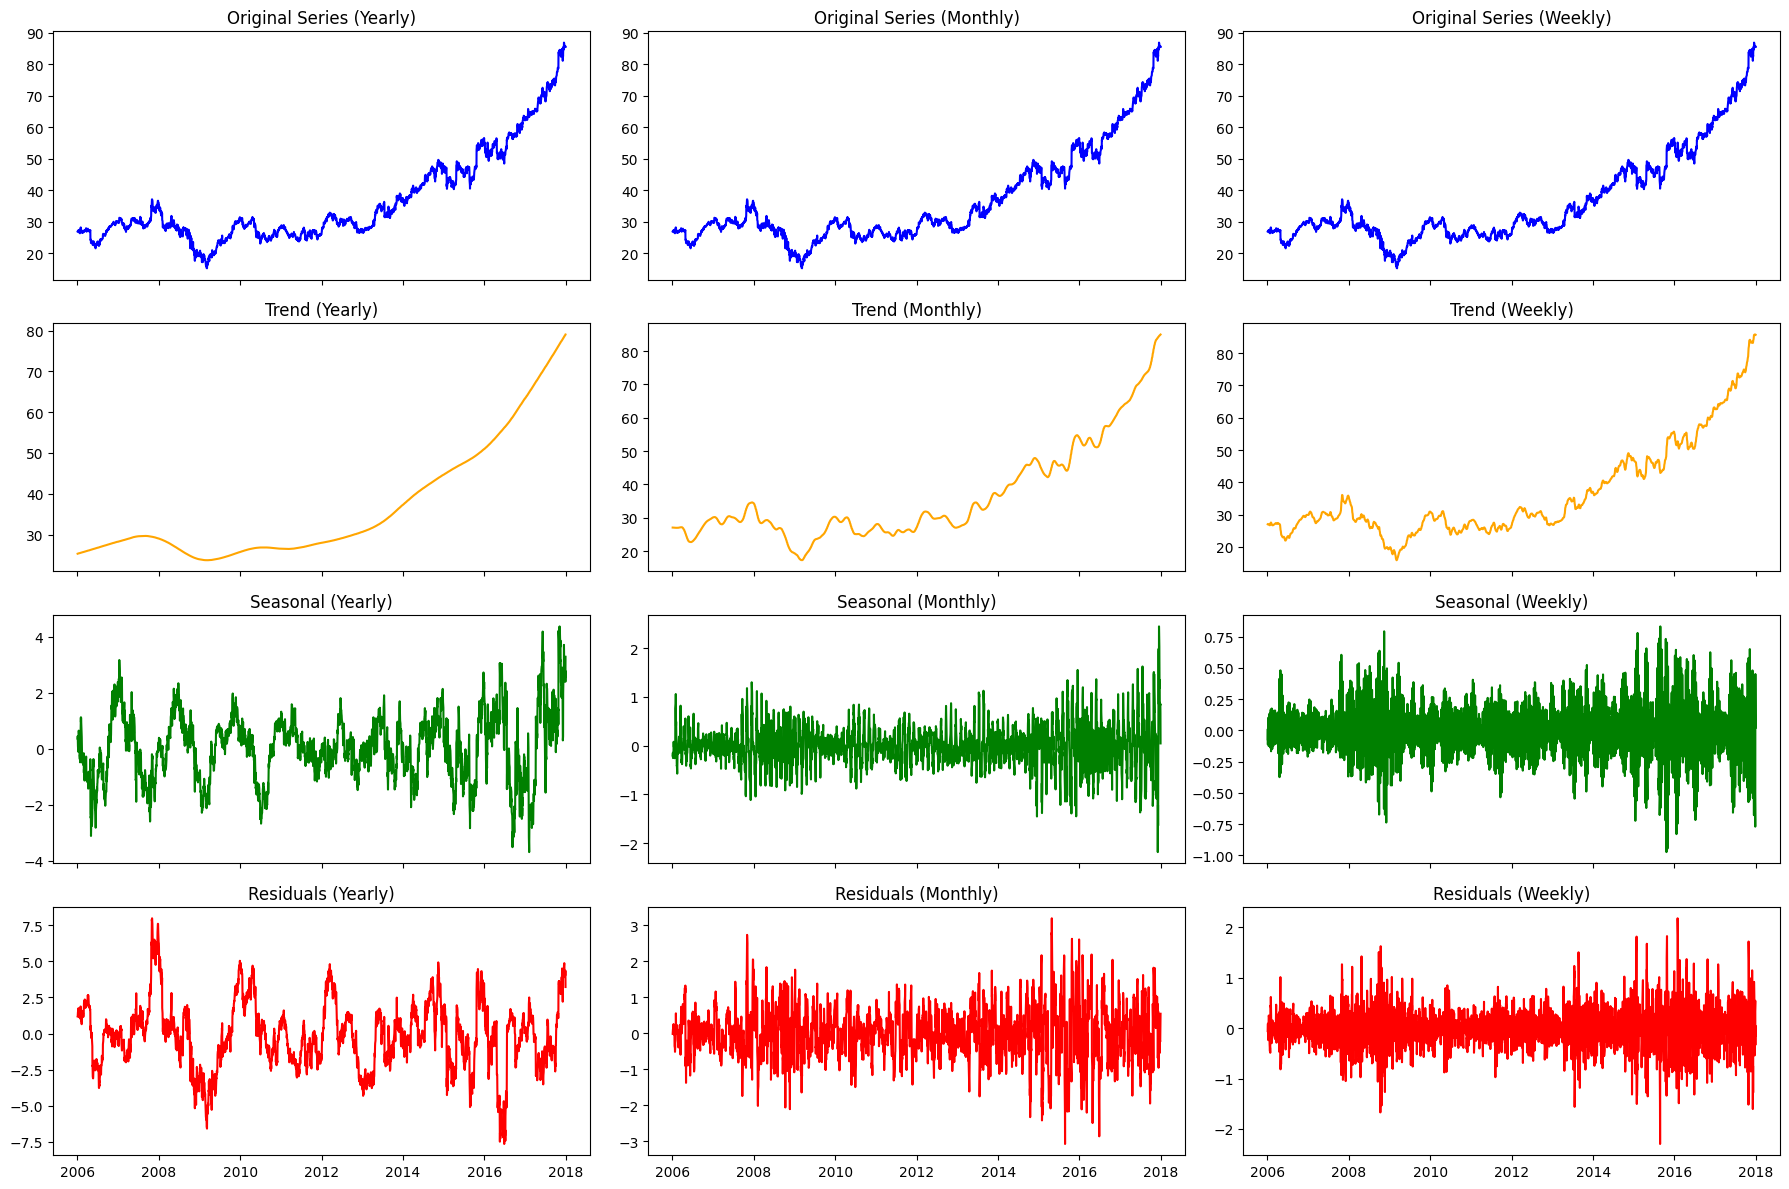

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# Yearly Seasonality (252 trading days for stock market data)
stl_yearly = STL(data['Close'], period=365)
result_yearly = stl_yearly.fit()

# Monthly Seasonality (approx. 30 days)
stl_monthly = STL(data['Close'], period=30)
result_monthly = stl_monthly.fit()

# Weekly Seasonality (7 days)
stl_weekly = STL(data['Close'], period=7)
result_weekly = stl_weekly.fit()

# Plotting the decompositions for yearly, monthly, and weekly seasonal components
fig, axes = plt.subplots(4, 3, figsize=(18, 12), sharex=True)

# Yearly decomposition
axes[0, 0].plot(data['Date'], data['Close'], color='blue')
axes[0, 0].set_title('Original Series (Yearly)')

axes[1, 0].plot(data['Date'], result_yearly.trend, color='orange')
axes[1, 0].set_title('Trend (Yearly)')

axes[2, 0].plot(data['Date'], result_yearly.seasonal, color='green')
axes[2, 0].set_title('Seasonal (Yearly)')

axes[3, 0].plot(data['Date'], result_yearly.resid, color='red')
axes[3, 0].set_title('Residuals (Yearly)')

# Monthly decomposition
axes[0, 1].plot(data['Date'], data['Close'], color='blue')
axes[0, 1].set_title('Original Series (Monthly)')

axes[1, 1].plot(data['Date'], result_monthly.trend, color='orange')
axes[1, 1].set_title('Trend (Monthly)')

axes[2, 1].plot(data['Date'], result_monthly.seasonal, color='green')
axes[2, 1].set_title('Seasonal (Monthly)')

axes[3, 1].plot(data['Date'], result_monthly.resid, color='red')
axes[3, 1].set_title('Residuals (Monthly)')

# Weekly decomposition
axes[0, 2].plot(data['Date'], data['Close'], color='blue')
axes[0, 2].set_title('Original Series (Weekly)')

axes[1, 2].plot(data['Date'], result_weekly.trend, color='orange')
axes[1, 2].set_title('Trend (Weekly)')

axes[2, 2].plot(data['Date'], result_weekly.seasonal, color='green')
axes[2, 2].set_title('Seasonal (Weekly)')

axes[3, 2].plot(data['Date'], result_weekly.resid, color='red')
axes[3, 2].set_title('Residuals (Weekly)')

plt.tight_layout()
plt.show()

In [ ]:
data.set_index('Date', inplace=True)
# Resample and forward fill: If needed to ensure continuous data with daily frequency
data_resampled = data.resample('D').ffill()

# Interpolating: If needed for synchronization with other variables
data_interpolated = data.resample('D').interpolate(method='linear')


#But for now we think its not needed

Our data represents actual trading days, and market closures (e.g., weekends and holidays) which is natural behavior of stock market. Filling these gaps may not add meaningful information and also stock prices are highly dependent on trading volume, market activity, and events that happen during trading sessions. Including synthetic data for non-trading days might distort the predictive behavior.

In [ ]:
# Check for missing values in the dataset
missing_summary = data.isnull().sum()
print("Missing values summary before interpolation:")
print(missing_summary)

Missing values summary before interpolation:
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [ ]:
# Interpolating all numerical columns in the DataFrame to ensure continuity and alignment
data_aligned = data.interpolate(method='linear')

# Display the first few rows to confirm that data is consistently measured and interpolated if needed
print(data_aligned.head())

             Open   High    Low  Close     Volume
Date                                             
2006-01-03  26.25  27.00  26.10  26.84   79974418
2006-01-04  26.77  27.08  26.77  26.97   57975661
2006-01-05  26.96  27.13  26.91  26.99   48247610
2006-01-06  26.89  27.00  26.49  26.91  100969092
2006-01-09  26.93  27.07  26.76  26.86   55627836


Our data is already synchronized across variables since interpolation didn't change it. It was expected because we didn't have any missing values. This confirms that all variables are measured at consistent intervals without any missing data.

In [ ]:
# Ensure 'Date' is set as the index and in chronological order
data = data.sort_index()

# Generate a complete date range for the desired frequency (e.g., daily)
complete_index = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')

# Identify missing dates
missing_dates = complete_index.difference(data.index)

print("Missing dates:", missing_dates)


Missing dates: DatetimeIndex(['2006-01-07', '2006-01-08', '2006-01-14', '2006-01-15',
               '2006-01-16', '2006-01-21', '2006-01-22', '2006-01-28',
               '2006-01-29', '2006-02-04',
               ...
               '2017-11-26', '2017-12-02', '2017-12-03', '2017-12-09',
               '2017-12-10', '2017-12-16', '2017-12-17', '2017-12-23',
               '2017-12-24', '2017-12-25'],
              dtype='datetime64[ns]', length=1360, freq=None)


**Expected behavior for financial datasets because of weekends and holidays.**

For stock market analysis, it is better to maintain data as trading-only data (no resampling) because filling the non-trading days may provide some noise.
we can use forward filling or interpolation only if our prediction model requires continuous data.

<ipython-input-120-ece75de96dc3>:14: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  outlier_values = result.resid[data.index.isin(outlier_dates)]


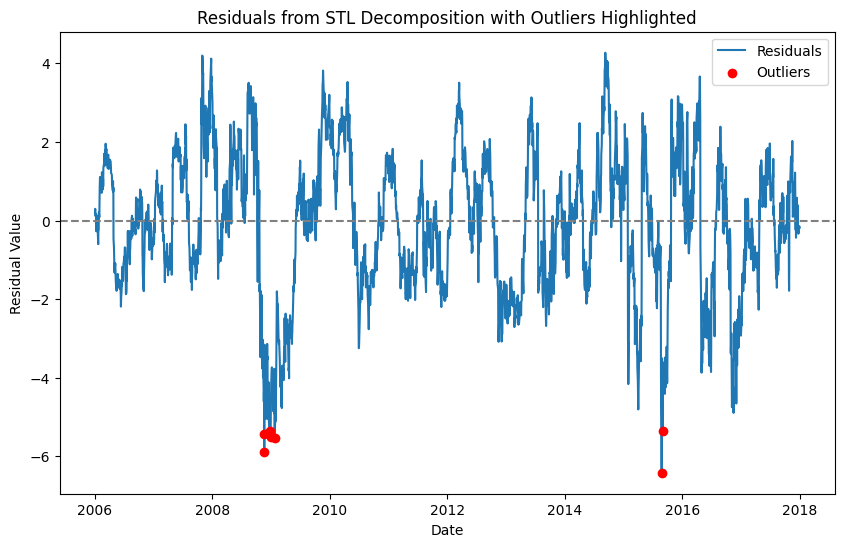

In [ ]:
import matplotlib.pyplot as plt

# Plotting residuals
plt.figure(figsize=(10, 6))
plt.plot(data.index, result.resid, label='Residuals')
plt.axhline(y=0, color='gray', linestyle='--')
plt.title('Residuals from STL Decomposition with Outliers Highlighted')
plt.xlabel('Date')
plt.ylabel('Residual Value')

# Highlighting the outlier points
outlier_dates = ['2008-11-19', '2008-11-20', '2008-12-24', '2008-12-29',
                 '2009-01-23', '2015-08-25', '2015-09-01']
outlier_values = result.resid[data.index.isin(outlier_dates)]
plt.scatter(outlier_dates, outlier_values, color='red', zorder=5, label='Outliers')

plt.legend()
plt.show()


In [ ]:
residuals = result.resid

# Calculate threshold for outlier detection (e.g., 3 times the standard deviation)
threshold = 3 * np.std(residuals)

# Identify points where the residual exceeds the threshold
outliers = np.abs(residuals) > threshold
outlier_dates = data.index[outliers]
print("Outlier Dates:")
print(outlier_dates)


Outlier Dates:
DatetimeIndex(['2008-11-19', '2008-11-20', '2008-12-24', '2008-12-29',
               '2009-01-23', '2015-08-25', '2015-09-01'],
              dtype='datetime64[ns]', name='Date', freq=None)


We think that these dates are not outliers and maybe at that time there was some significant market events and crisis. So we want to keep them but be carefull during our following analysis.

In [ ]:
import pandas_market_calendars as mcal
import pandas as pd

# Ensure 'Date' column is in datetime format and set it as the index
#data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
#data = data.set_index('Date')

# Get the market calendar for the New York Stock Exchange (NYSE)
nyse = mcal.get_calendar('NYSE')

# Define the date range based on your specified range
start_date = '2006-01-03'
end_date = '2017-12-29'

# Get the trading schedule for the given date range
schedule = nyse.schedule(start_date=start_date, end_date=end_date)
trading_days = schedule.index

# Filter the data to include only market open days
data = data[data.index.isin(trading_days)]

# Display the filtered data
print(data.head())

             Open   High    Low  Close     Volume
Date                                             
2006-01-03  26.25  27.00  26.10  26.84   79974418
2006-01-04  26.77  27.08  26.77  26.97   57975661
2006-01-05  26.96  27.13  26.91  26.99   48247610
2006-01-06  26.89  27.00  26.49  26.91  100969092
2006-01-09  26.93  27.07  26.76  26.86   55627836


#First: A simple Autoregressive model + cross-validation

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


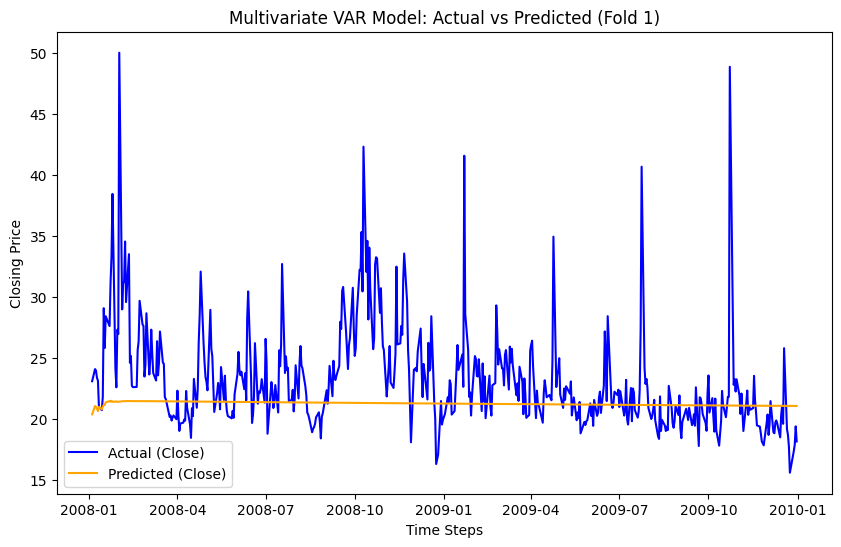

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


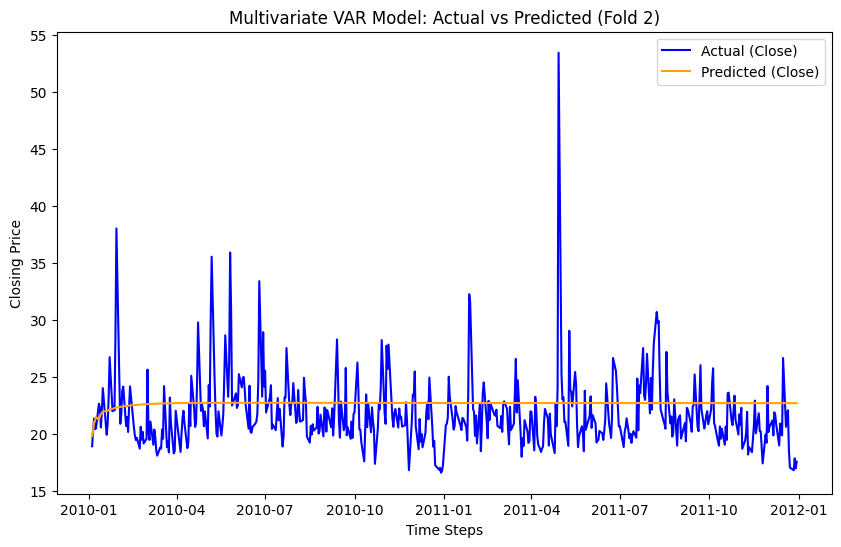

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


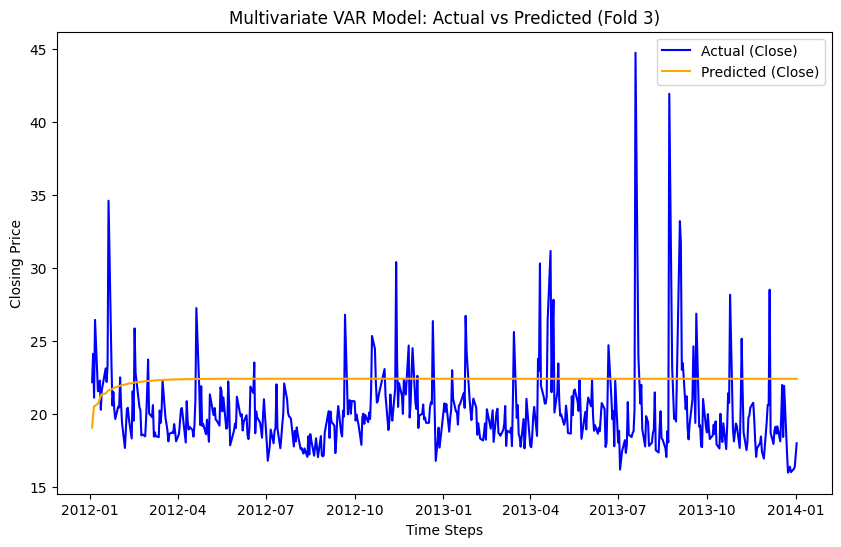

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


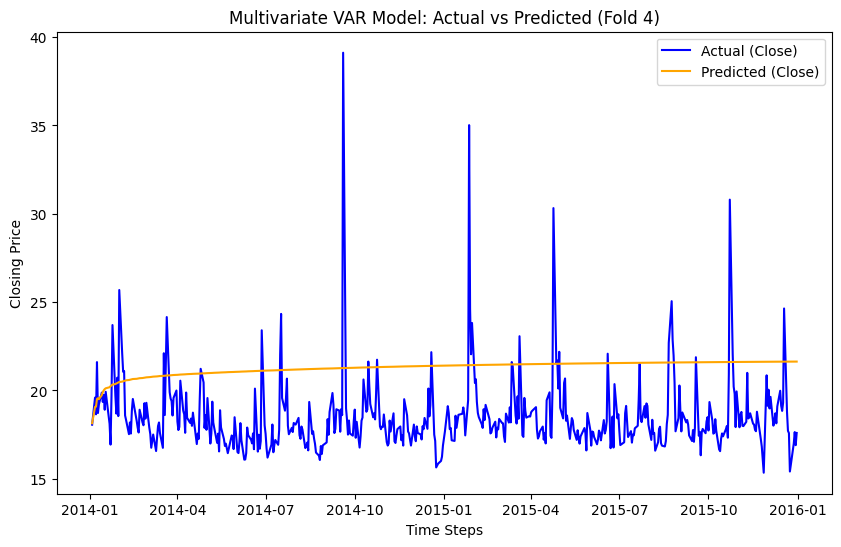

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


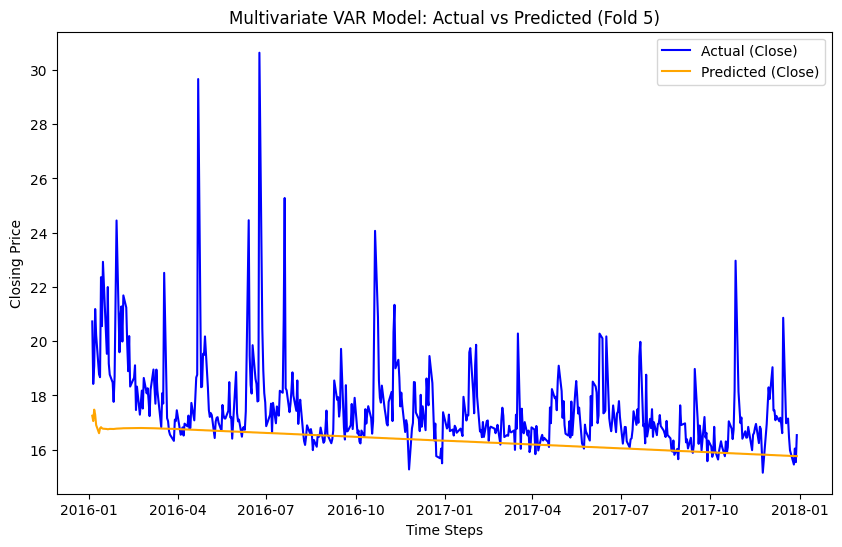

   Fold        MSE      RMSE       MAPE        R2   Accuracy
0     1  20.787328  4.559312  11.200590 -0.215798  88.799410
1     2  10.490167  3.238853  10.724819 -0.078008  89.275181
2     3  12.869320  3.587383  15.275508 -0.664665  84.724492
3     4  12.341184  3.513002  17.546356 -1.871440  82.453644
4     5   3.724241  1.929829   6.502058 -0.422720  93.497942


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Separate features and target
features = data.drop(columns=['Close']).values
target = data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

normalized_features = scaler_features.fit_transform(features)
normalized_target = scaler_target.fit_transform(target)

# Combine normalized features and target into one DataFrame
normalized_data = np.hstack([normalized_features, normalized_target])
df = pd.DataFrame(normalized_data, columns=[*data.columns], index=data.index)

# Initialize time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Store metrics for each fold
metrics = []

for fold, (train_index, test_index) in enumerate(tscv.split(df), 1):
    train, test = df.iloc[train_index], df.iloc[test_index]

    # Fit the VAR (Vector AutoRegression) model
    model = VAR(train)
    model_fitted = model.fit(ic='aic')

    # Forecasting
    pred = model_fitted.forecast(y=train.values[-10:], steps=len(test))

    # Extract the predicted values for 'Close'
    predictions = pred[:, df.columns.get_loc('Close')]

    # Inverse transform the predicted and actual 'Close' values
    test_actual = scaler_target.inverse_transform(test['Close'].values.reshape(-1, 1))
    predictions = scaler_target.inverse_transform(predictions.reshape(-1, 1))

    # Calculate metrics
    mse = mean_squared_error(test_actual, predictions)
    mape = mean_absolute_percentage_error(test_actual, predictions) * 100
    rmse = np.sqrt(mse)
    r2 = r2_score(test_actual, predictions)

    # Store metrics for this fold
    metrics.append({
        'Fold': fold,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2,
        'Accuracy': 100 - mape  # Derived from MAPE
    })

    # Plot the results for this fold
    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test_actual, label='Actual (Close)', color='blue')
    plt.plot(test.index, predictions, label='Predicted (Close)', color='orange')
    plt.xlabel('Time Steps')
    plt.ylabel('Closing Price')
    plt.title(f'Multivariate VAR Model: Actual vs Predicted (Fold {fold})')
    plt.legend()
    plt.show()

# Display metrics for each fold
import pandas as pd
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

#Advanced Model

#LSTM

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0115 - val_loss: 0.0011
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 6.6952e-04 - val_loss: 0.0014
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 6.3128e-04 - val_loss: 4.5141e-04
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.8638e-04 - val_loss: 4.6115e-04
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.1521e-04 - val_loss: 0.0015
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.1105e-04 - val_loss: 0.0018
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.6983e-04 - val_loss: 7.1593e-04
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.8405e-04 - val_loss: 9.4052e-04
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.8448e-04 - val_loss: 0.0012
Epoch 10/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.4370e-04 - val_loss: 0.0011
Epoch 11/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.2100e-04 - val_loss: 0.0012
Epoch 12/50
76/76 

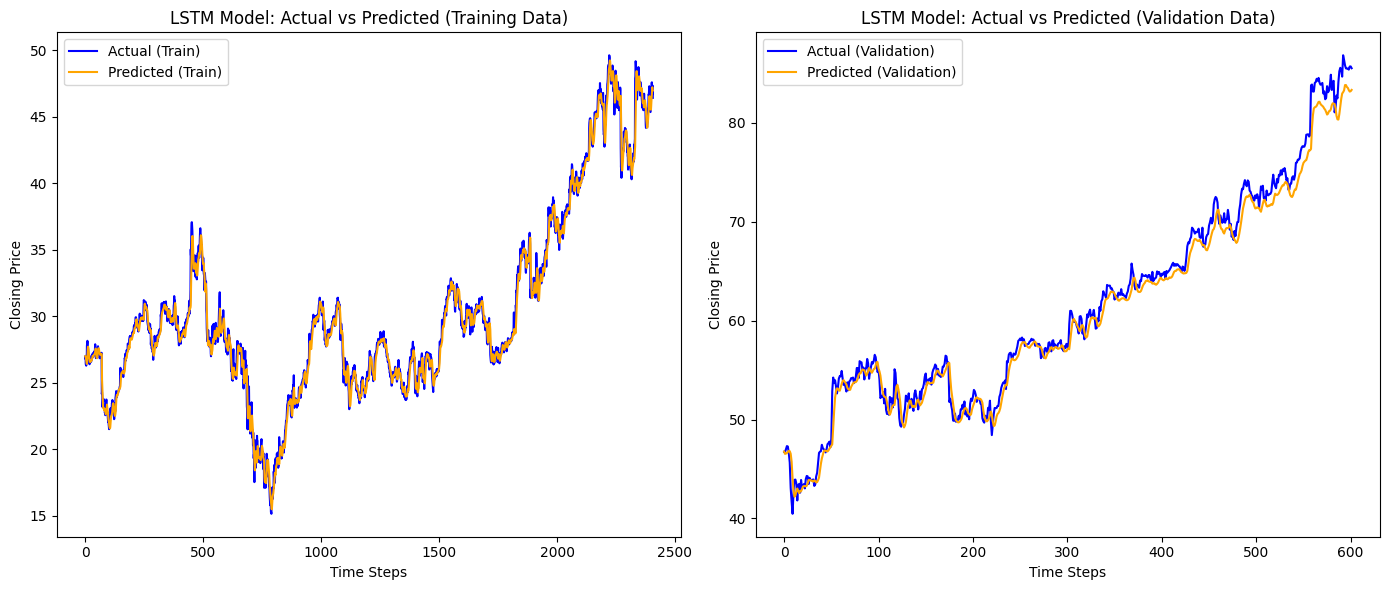

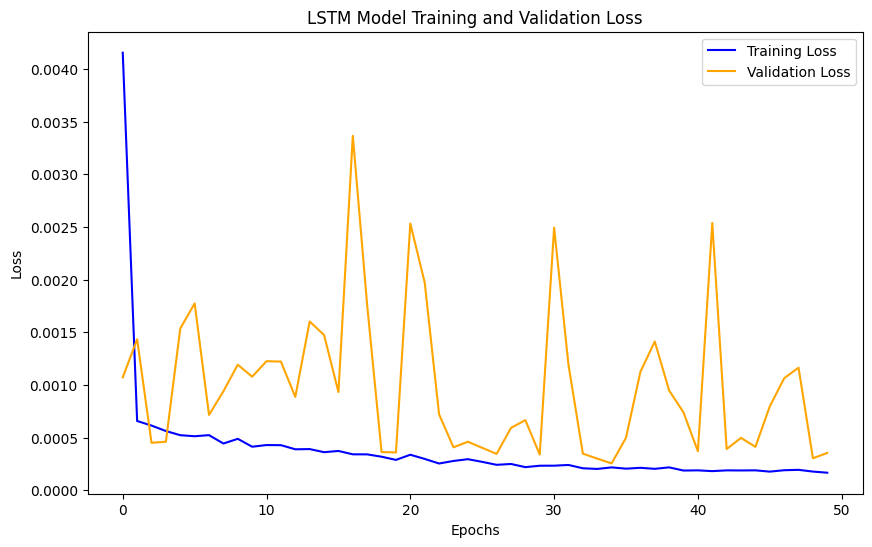

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Separate features and target
features = data.drop(columns=['Close']).values
target = data['Close'].values.reshape(-1, 1)

# Normalize features and target separately
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

features = scaler_features.fit_transform(features)
target = scaler_target.fit_transform(target)

# Create sequences for LSTM
def create_sequences(features, target, time_steps=10):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:i+time_steps])
        y.append(target[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 10  # Number of time steps to look back
X, y = create_sequences(features, target, time_steps)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Make predictions for training data
y_train_pred = model.predict(X_train)
# Make predictions for testing (validation) data
y_test_pred = model.predict(X_test)

# Inverse transform the predicted and actual values for comparison
y_train = scaler_target.inverse_transform(y_train)
y_train_pred = scaler_target.inverse_transform(y_train_pred)
y_test = scaler_target.inverse_transform(y_test)
y_test_pred = scaler_target.inverse_transform(y_test_pred)

# Plot the training and validation predictions
plt.figure(figsize=(14, 6))

# Training data comparison
plt.subplot(1, 2, 1)
plt.plot(y_train, label='Actual (Train)', color='blue')
plt.plot(y_train_pred, label='Predicted (Train)', color='orange')
plt.title('LSTM Model: Actual vs Predicted (Training Data)')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()

# Validation data comparison
plt.subplot(1, 2, 2)
plt.plot(y_test, label='Actual (Validation)', color='blue')
plt.plot(y_test_pred, label='Predicted (Validation)', color='orange')
plt.title('LSTM Model: Actual vs Predicted (Validation Data)')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()

plt.tight_layout()
plt.show()

# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Model Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAPE and accuracy for training data
mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
accuracy_train = 100 - mape_train

# Calculate MAPE and accuracy for validation (testing) data
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
accuracy_test = 100 - mape_test

print(f"Training Data Accuracy: {accuracy_train:.2f}%")
print(f"Validation Data Accuracy: {accuracy_test:.2f}%")


Training Data Accuracy: 98.28%
Validation Data Accuracy: 98.34%


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0097 - val_loss: 4.4509e-04
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.7629e-04 - val_loss: 6.1063e-04
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 6.0370e-04 - val_loss: 7.8185e-04
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.5100e-04 - val_loss: 6.9321e-04
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.3282e-04 - val_loss: 8.5416e-04
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.3700e-04 - val_loss: 0.0020
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.4923e-04 - val_loss: 6.2039e-04
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.3312e-04 - val_loss: 0.0017
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.9907e-04 - val_loss: 0.0027
Epoch 10/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 4.8538e-04 - val_loss: 0.0011
Epoch 11/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 3.9349e-04 - val_loss: 5.0819e-04
Epoch 

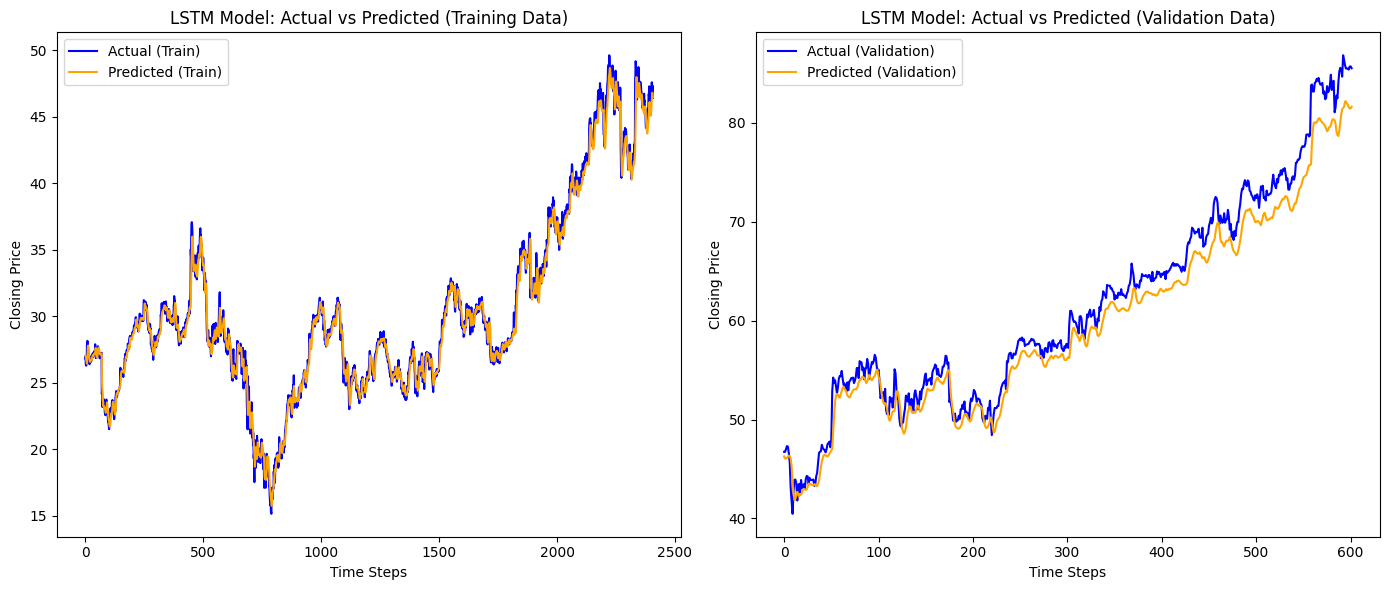

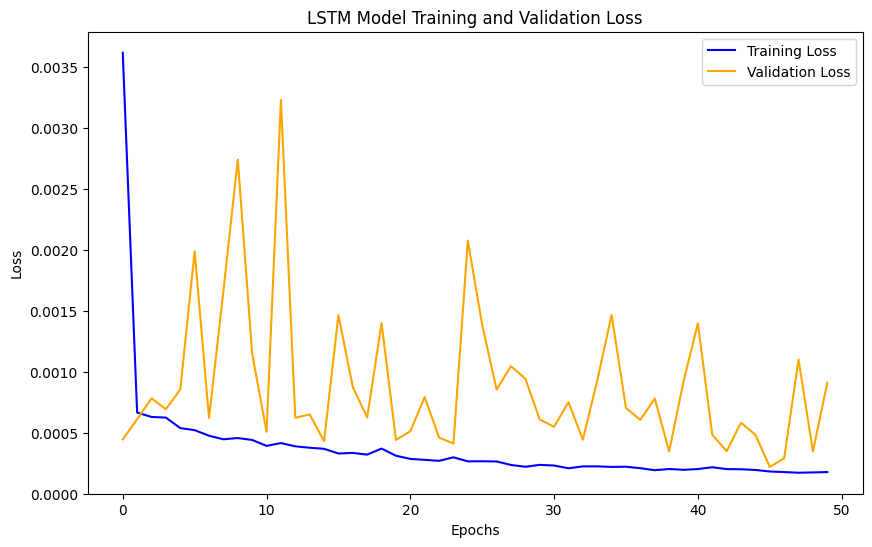

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Separate features and target
features = data.drop(columns=['Close']).values
target = data['Close'].values.reshape(-1, 1)

# Normalize features and target separately
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

features = scaler_features.fit_transform(features)
target = scaler_target.fit_transform(target)

# Create sequences for LSTM
def create_sequences(features, target, time_steps=10):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:i+time_steps])
        y.append(target[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 10  # Number of time steps to look back
X, y = create_sequences(features, target, time_steps)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Make predictions for training and testing data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Inverse transform the predicted and actual values for comparison
y_train = scaler_target.inverse_transform(y_train)
y_train_pred = scaler_target.inverse_transform(y_train_pred)
y_test = scaler_target.inverse_transform(y_test)
y_test_pred = scaler_target.inverse_transform(y_test_pred)

# Calculate metrics for training data
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_train_pred) * 100
r2_train = r2_score(y_train, y_train_pred)
accuracy_train = 100 - mape_train

# Calculate metrics for testing data
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred) * 100
r2_test = r2_score(y_test, y_test_pred)
accuracy_test = 100 - mape_test

# Print metrics
print("----- Training Metrics -----")
print(f"MSE: {mse_train:.4f}, RMSE: {rmse_train:.4f}, MAPE: {mape_train:.2f}%, R²: {r2_train:.4f}, Accuracy: {accuracy_train:.2f}%")
print("----- Testing Metrics -----")
print(f"MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}, MAPE: {mape_test:.2f}%, R²: {r2_test:.4f}, Accuracy: {accuracy_test:.2f}%")

# Plot the training and validation predictions
plt.figure(figsize=(14, 6))

# Training data comparison
plt.subplot(1, 2, 1)
plt.plot(y_train, label='Actual (Train)', color='blue')
plt.plot(y_train_pred, label='Predicted (Train)', color='orange')
plt.title('LSTM Model: Actual vs Predicted (Training Data)')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()

# Validation data comparison
plt.subplot(1, 2, 2)
plt.plot(y_test, label='Actual (Validation)', color='blue')
plt.plot(y_test_pred, label='Predicted (Validation)', color='orange')
plt.title('LSTM Model: Actual vs Predicted (Validation Data)')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()

plt.tight_layout()
plt.show()

# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Model Training and Validation Loss')
plt.legend()
plt.show()


#RNN

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1739 - val_loss: 0.0382
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0146 - val_loss: 0.0215
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0086 - val_loss: 0.0078
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0065 - val_loss: 0.0160
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0049 - val_loss: 0.0137
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0045 - val_loss: 0.0127
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0036 - val_loss: 0.0071
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0028 - val_loss: 0.0073
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0025 - val_loss: 0.0089
Epoch 10/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0023 - val_loss: 0.0056
Epoch 11/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019 - val_loss: 0.0069
Epoch 12/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0018 - v

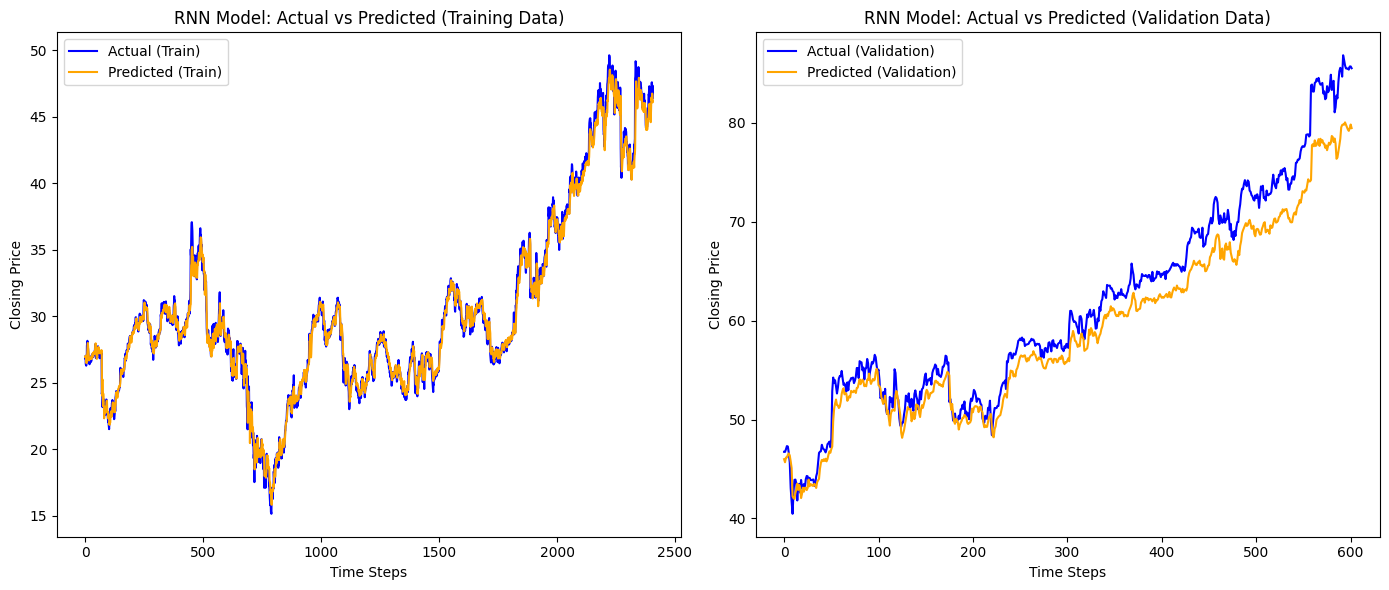

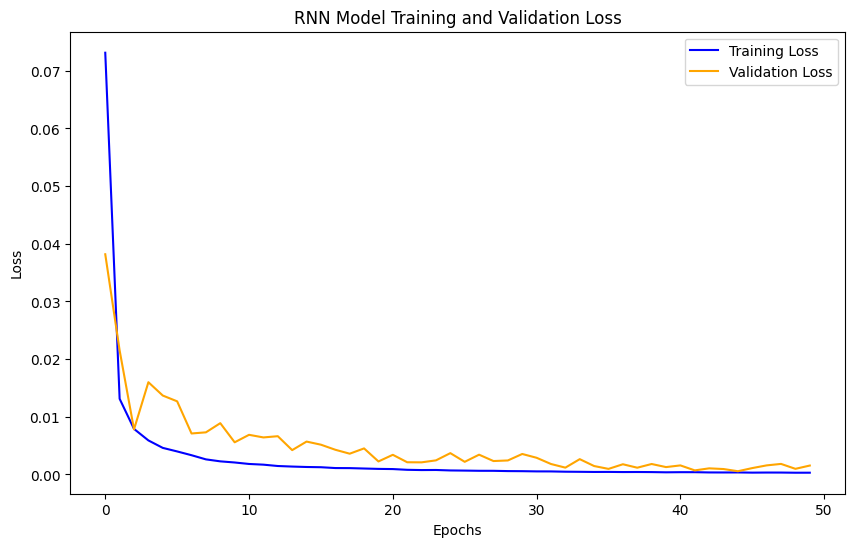

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
import matplotlib.pyplot as plt

# Separate features and target
features = data.drop(columns=['Close']).values
target = data['Close'].values.reshape(-1, 1)

# Normalize features and target separately
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

features = scaler_features.fit_transform(features)
target = scaler_target.fit_transform(target)

# Create sequences for RNN
def create_sequences(features, target, time_steps=10):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:i+time_steps])
        y.append(target[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 10  # Number of time steps to look back
X, y = create_sequences(features, target, time_steps)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build the RNN model
model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(SimpleRNN(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Make predictions for training and testing (validation) data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Inverse transform the predicted and actual values for comparison
y_train = scaler_target.inverse_transform(y_train)
y_train_pred = scaler_target.inverse_transform(y_train_pred)
y_test = scaler_target.inverse_transform(y_test)
y_test_pred = scaler_target.inverse_transform(y_test_pred)

# Calculate metrics for training data
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_train_pred) * 100
r2_train = r2_score(y_train, y_train_pred)
accuracy_train = 100 - mape_train

# Calculate metrics for testing data
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred) * 100
r2_test = r2_score(y_test, y_test_pred)
accuracy_test = 100 - mape_test

# Print metrics
print("----- Training Metrics -----")
print(f"MSE: {mse_train:.4f}, RMSE: {rmse_train:.4f}, MAPE: {mape_train:.2f}%, R²: {r2_train:.4f}, Accuracy: {accuracy_train:.2f}%")
print("----- Testing Metrics -----")
print(f"MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}, MAPE: {mape_test:.2f}%, R²: {r2_test:.4f}, Accuracy: {accuracy_test:.2f}%")

# Plot the training and validation predictions
plt.figure(figsize=(14, 6))

# Training data comparison
plt.subplot(1, 2, 1)
plt.plot(y_train, label='Actual (Train)', color='blue')
plt.plot(y_train_pred, label='Predicted (Train)', color='orange')
plt.title('RNN Model: Actual vs Predicted (Training Data)')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()

# Validation data comparison
plt.subplot(1, 2, 2)
plt.plot(y_test, label='Actual (Validation)', color='blue')
plt.plot(y_test_pred, label='Predicted (Validation)', color='orange')
plt.title('RNN Model: Actual vs Predicted (Validation Data)')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()

plt.tight_layout()
plt.show()

# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('RNN Model Training and Validation Loss')
plt.legend()
plt.show()
